In [54]:
from lm_polygraph.utils.model import WhiteboxModel
from lm_polygraph.estimators import TokenSAR, MeanTokenEntropy
from lm_polygraph.utils.manager import estimate_uncertainty
import matplotlib.pyplot as plt
from utils import transfer_context_prompt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
from transformers import logging as transformers_logging

warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

In [2]:
model_path = "/share/nlp/chitchat/models/Llama-3.2-3B-Instruct/"
sampling_params = {
    'temperature':0.6,
    'top_k':50, 
    'top_p':0.9,
    'do_sample':False,
    'num_beams':1,
    'presence_penalty':0.0,
    'repetition_penalty':1.0, 
    'generate_until':(),
    'allow_newlines':True,
}

model = WhiteboxModel.from_pretrained(
    model_path=model_path, 
    generation_params=sampling_params,
    device_map="auto"
)

TokenSAR_method = TokenSAR()
MeanTokenEntropy_method = MeanTokenEntropy()

WhiteboxModel#from_pretrained is deprecated and will be removed in the next release. Please instantiate WhiteboxModel directly by passing an already loaded model, tokenizer and model path.
Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.14s/it]


## Normal context

In [3]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_utils.py:836: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat

In [4]:
eval_dataset['is_correct_without_context'] = [1, 1, 1, 0, 0.5, 1, 0, 0, 1, 1, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0, 0.5, 0, 0.5]
eval_dataset['is_correct_with_context'] = [1]*eval_dataset.shape[0]

In [5]:
eval_dataset.head()

,source,question,context,golden_answer,is_hard,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context,is_correct_without_context,is_correct_with_context
0,https://huggingface.co/datasets/rajpurkar/squad,What film inspired the name of the iPod?,"The name iPod was proposed by Vinnie Chieco, a...",2001: A Space Odyssey,0,"The film ""2001: A Space Odyssey"" (1968) inspir...",The film that inspired the name of the iPod is...,0.6380,0.3007,0.5548,0.1879,0.1578,0.1257,1.0,1
1,https://huggingface.co/datasets/rajpurkar/squad,What was the original name of Columbia Univers...,The trial in Manhattan of John Peter Zenger in...,King's College,0,King's College,King's College,0.3415,0.2723,0.3415,0.2723,0.0721,0.0263,1.0,1
2,https://huggingface.co/datasets/rajpurkar/squad,What is the average length of dog pregnancy?,Dogs bear their litters roughly 58 to 68 days ...,63 days,0,The average length of dog pregnancy is approxi...,63 days,0.5456,0.5676,0.4822,0.5676,0.1902,0.1696,1.0,1
3,https://huggingface.co/datasets/rajpurkar/squad,When did the Romans make Christianity their of...,The predominant religion is southern Europe is...,380 AD,0,The Romans did not make Christianity their off...,The Romans made Christianity their official re...,0.4663,0.3733,0.4292,0.2502,0.0532,0.1555,0.0,1
4,https://huggingface.co/datasets/rajpurkar/squad,Who was the Soviet minister who proposed Germa...,The Soviet request to join NATO arose in the a...,Molotov,0,I cannot verify who proposed German reunificat...,The Soviet minister who proposed German reunif...,1.1018,0.4248,0.9575,0.2761,0.9081,0.1704,0.5,1


In [6]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

/tmp/ipykernel_2678468/3028652670.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/3028652670.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


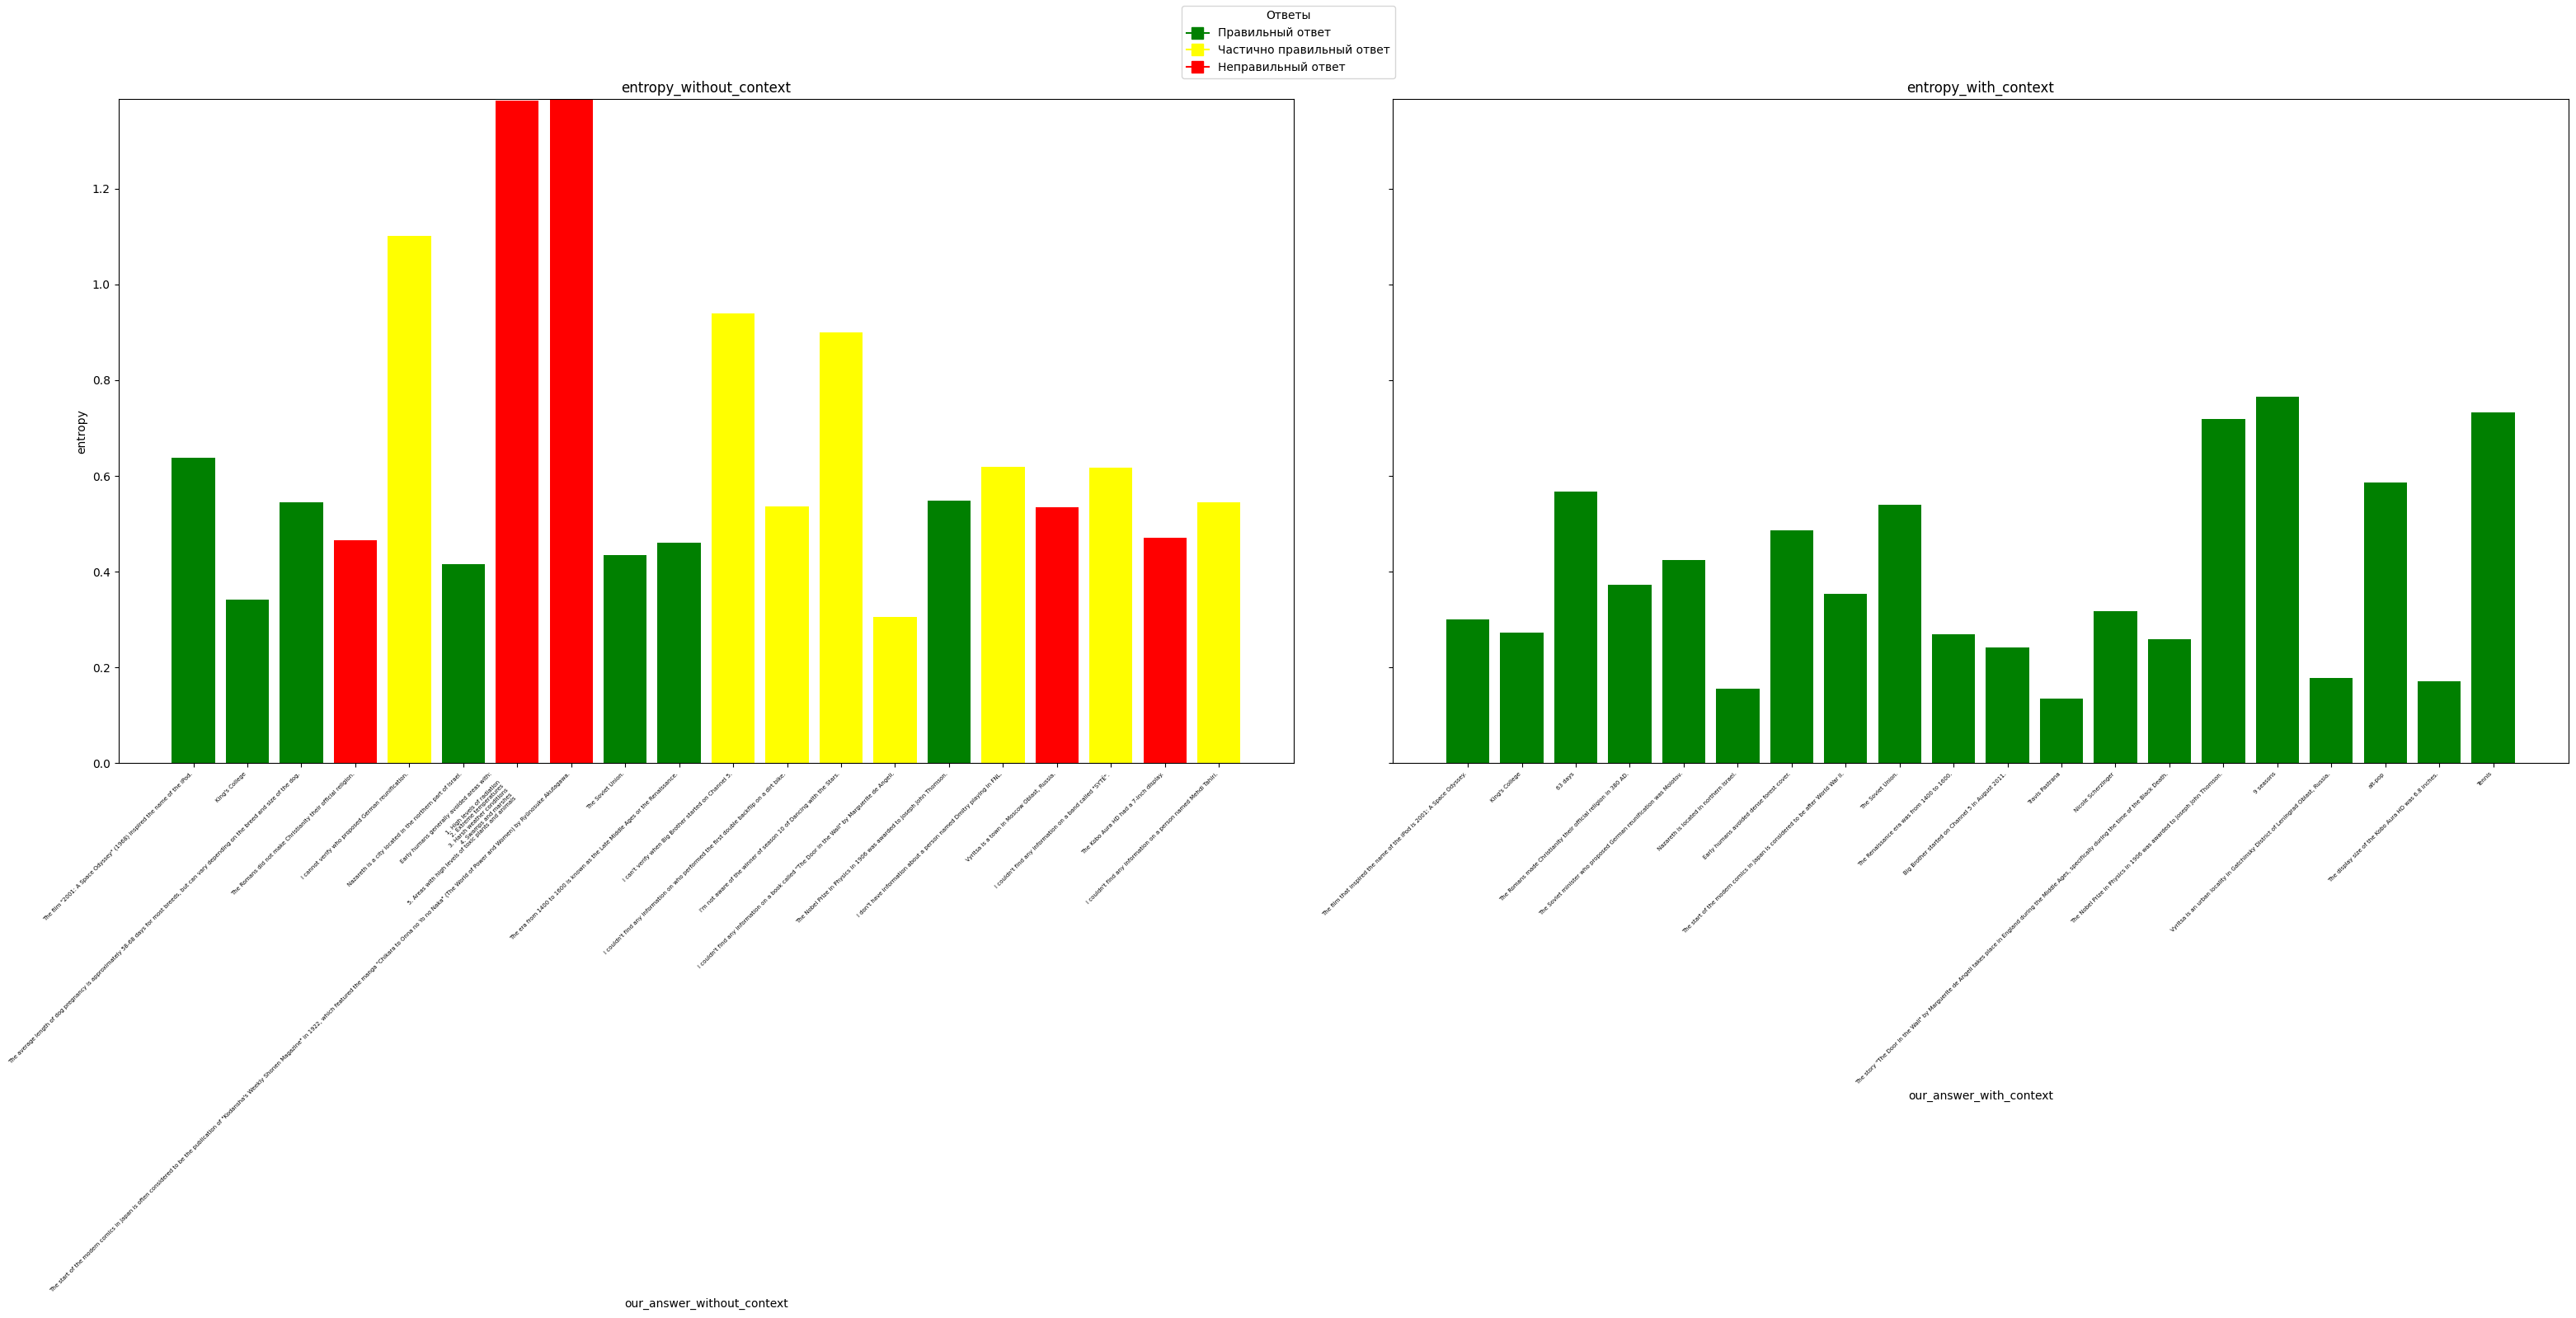

In [8]:
max_y = max(eval_dataset['entropy_without_context'].max(), eval_dataset['entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('entropy')
ax1.set_title('entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_2678468/3494639967.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/3494639967.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


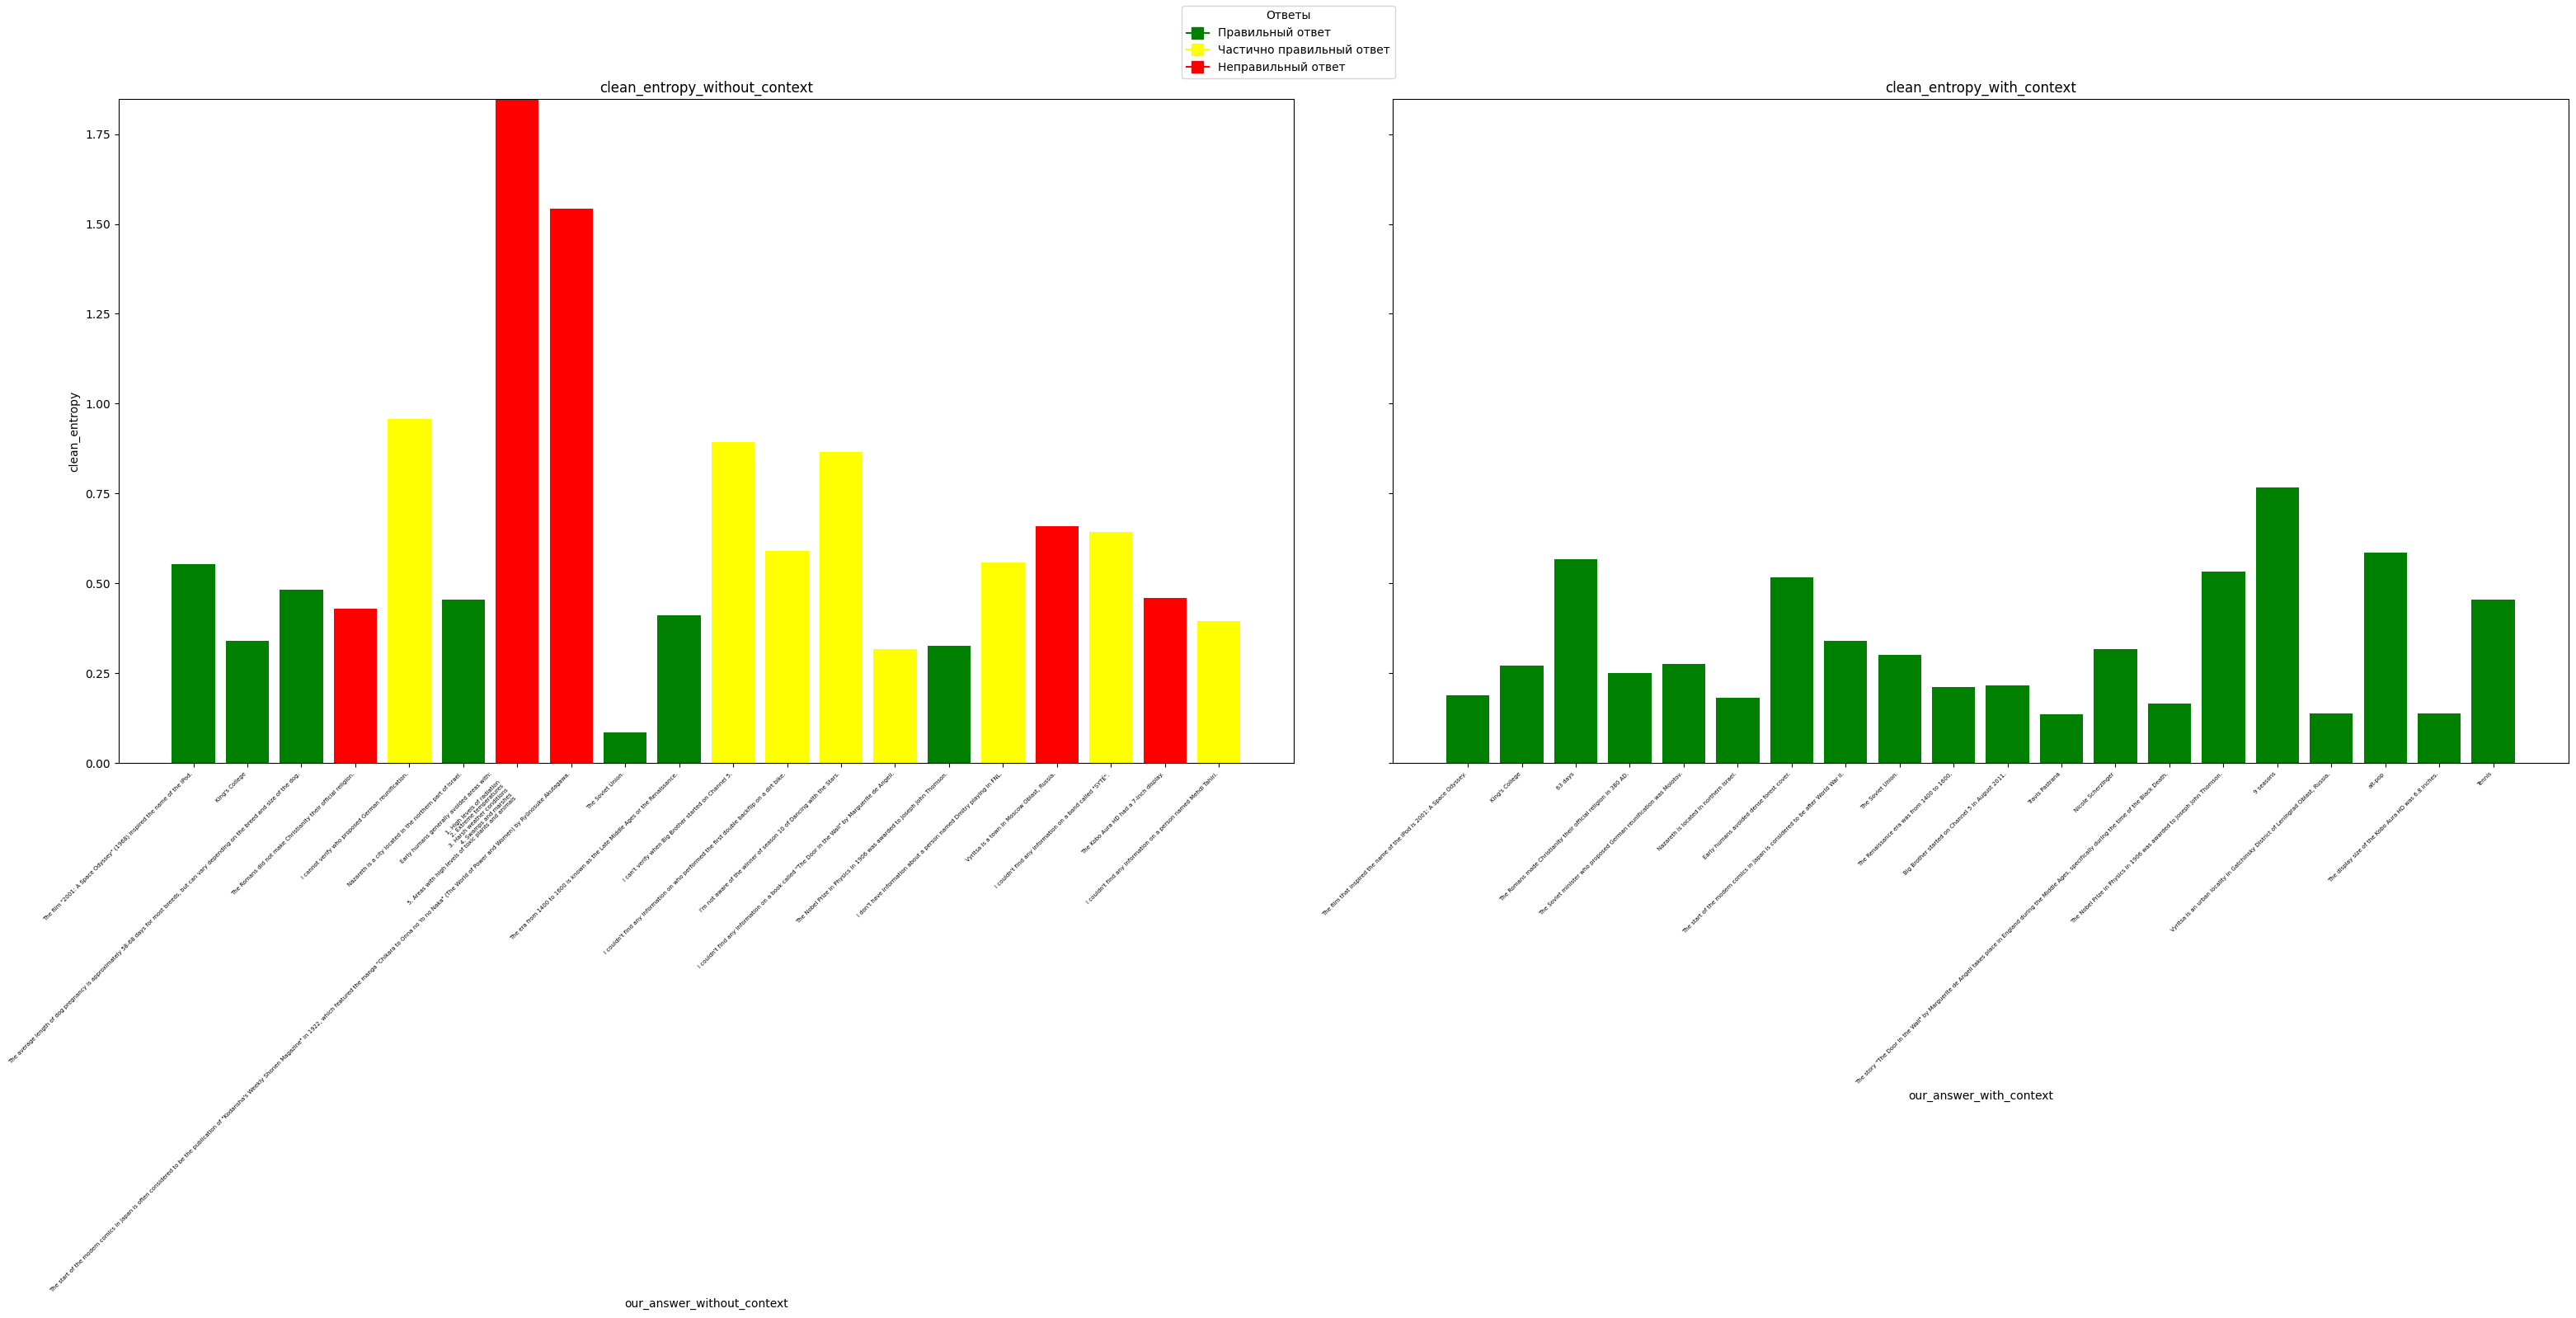

In [13]:
max_y = max(eval_dataset['clean_entropy_without_context'].max(), eval_dataset['clean_entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('clean_entropy')
ax1.set_title('clean_entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('clean_entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
eval_dataset.columns

Index(['source', 'question', 'context', 'golden_answer', 'is_hard',
       'our_answer_without_context', 'our_answer_with_context',
       'entropy_without_context', 'entropy_with_context',
       'clean_entropy_without_context', 'clean_entropy_with_context',
       'token_sar_without_context', 'token_sar_with_context',
       'is_correct_without_context', 'is_correct_with_context'],
      dtype='object')

/tmp/ipykernel_2678468/543706121.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/543706121.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


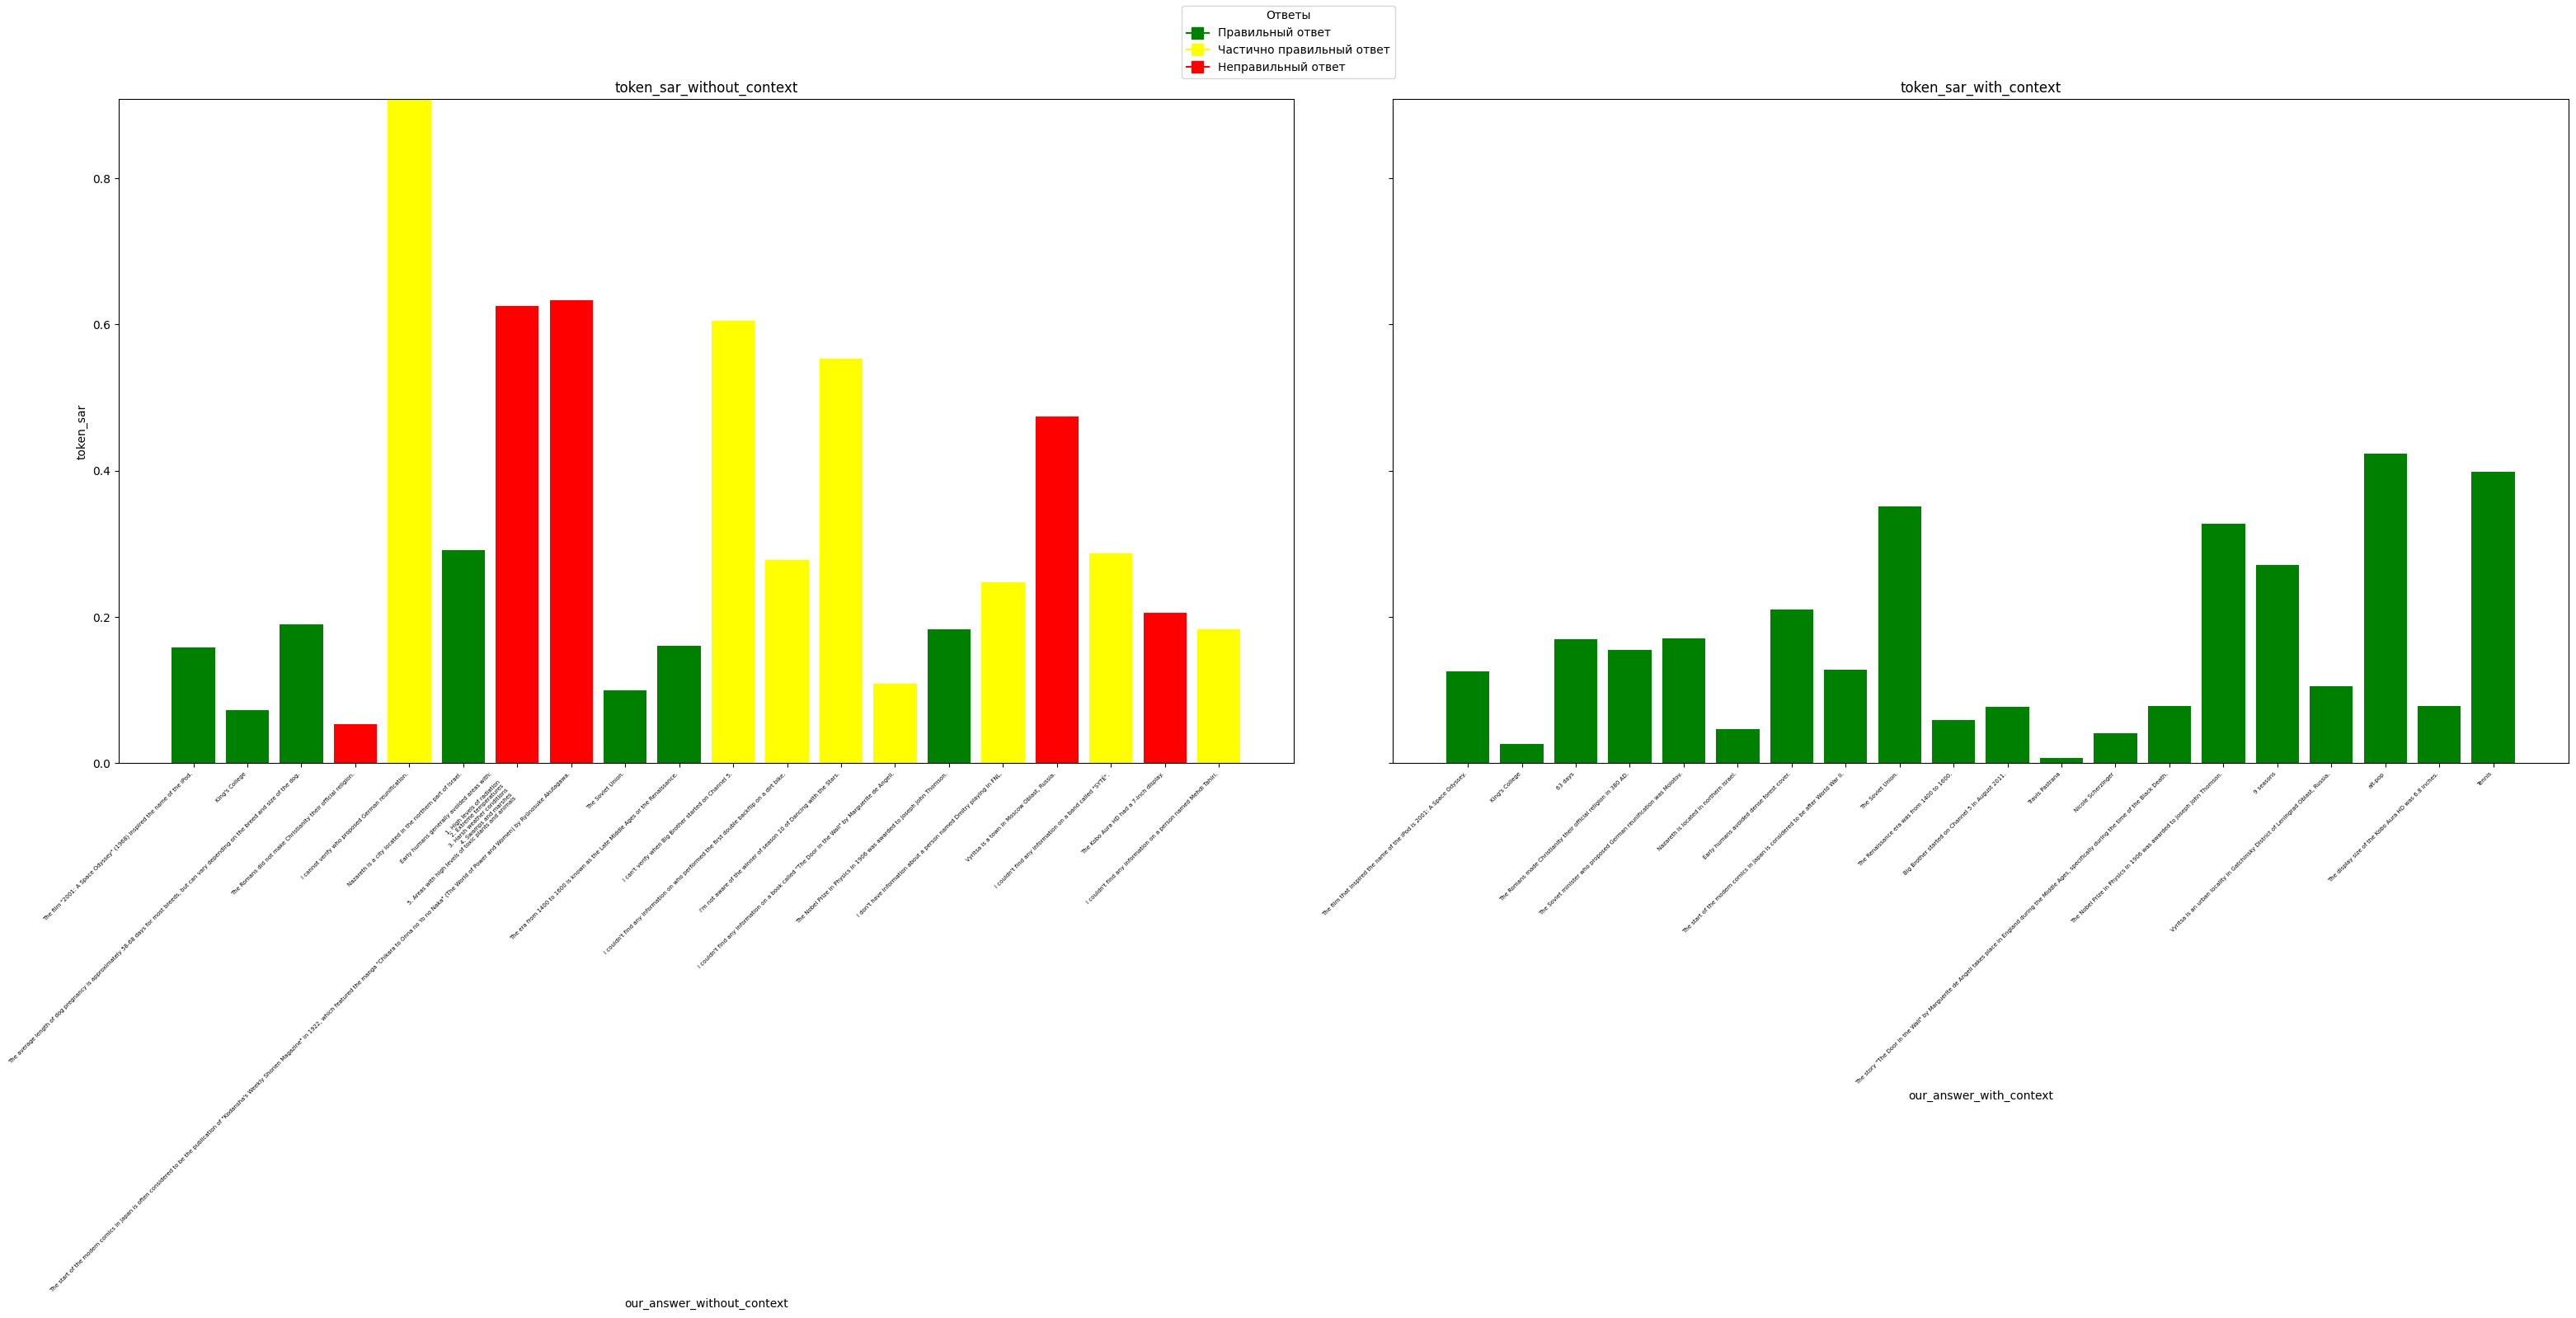

In [19]:
max_y = max(eval_dataset['token_sar_without_context'].max(), eval_dataset['token_sar_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('token_sar')
ax1.set_title('token_sar_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('token_sar_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Context perturbations

In [20]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset_context_perturbations.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context_perturbations']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

0it [00:00, ?it/s]Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dis

In [27]:
eval_dataset['is_correct_without_context'] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
eval_dataset['is_correct_with_context'] = [1, 0, 0, 0.5, 0, 0.5, 1]

In [28]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

/tmp/ipykernel_2678468/3028652670.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/3028652670.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


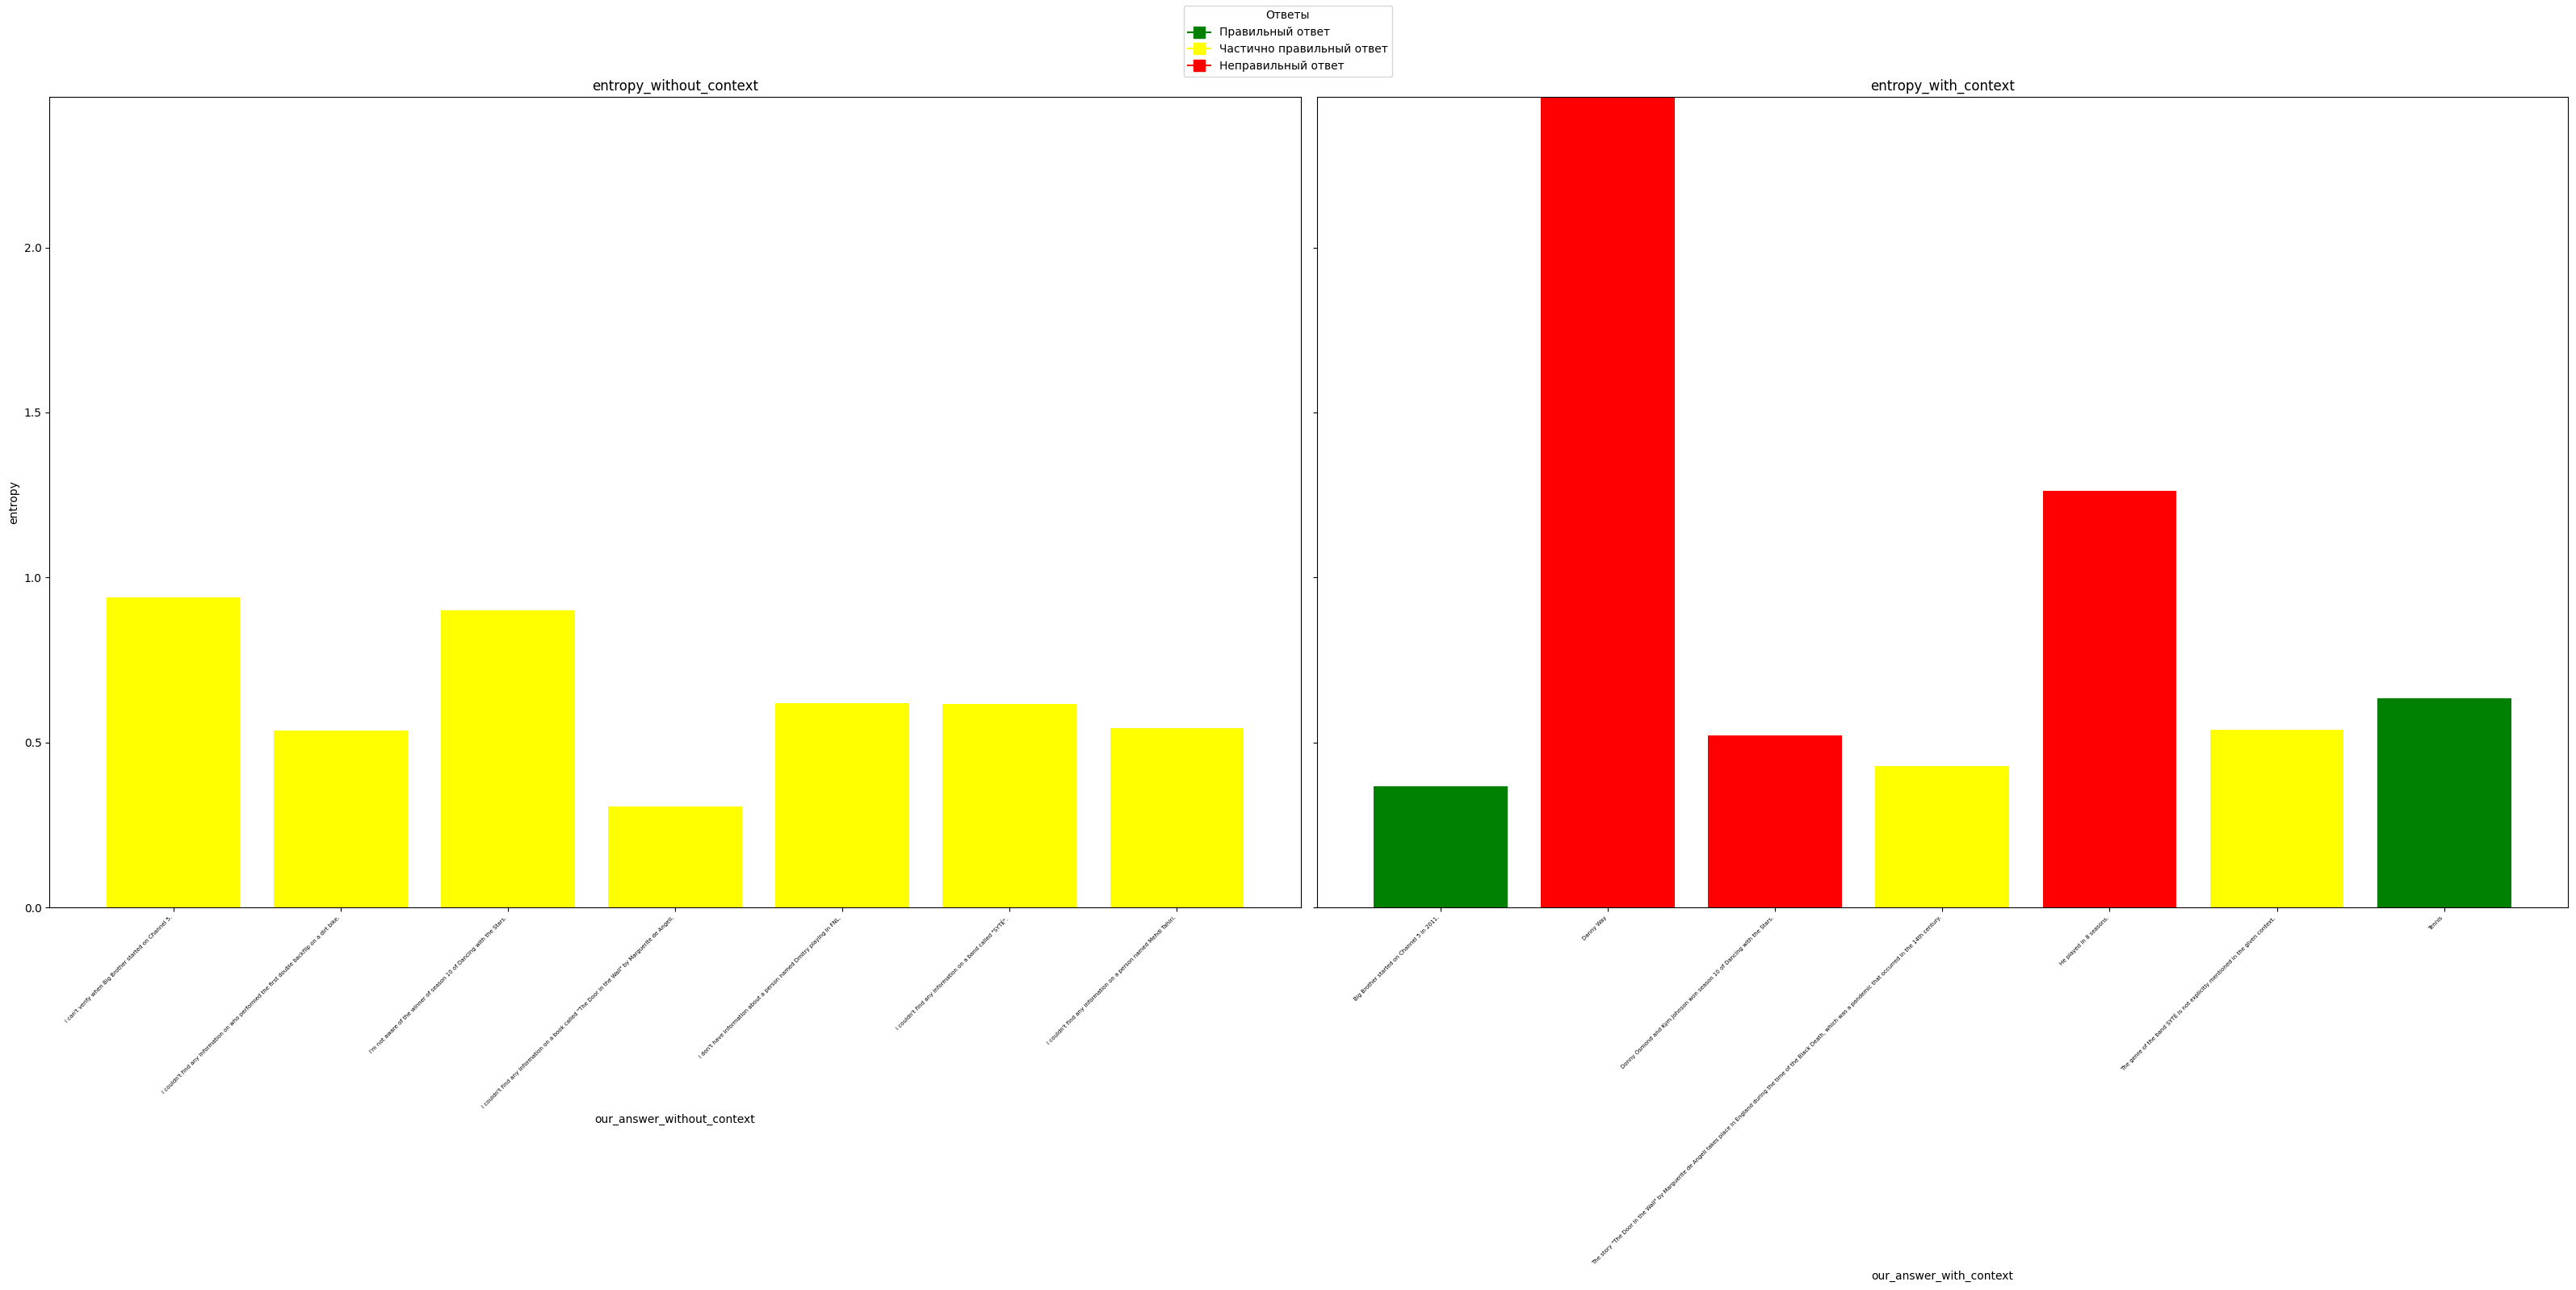

In [29]:
max_y = max(eval_dataset['entropy_without_context'].max(), eval_dataset['entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('entropy')
ax1.set_title('entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_2678468/3494639967.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/3494639967.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


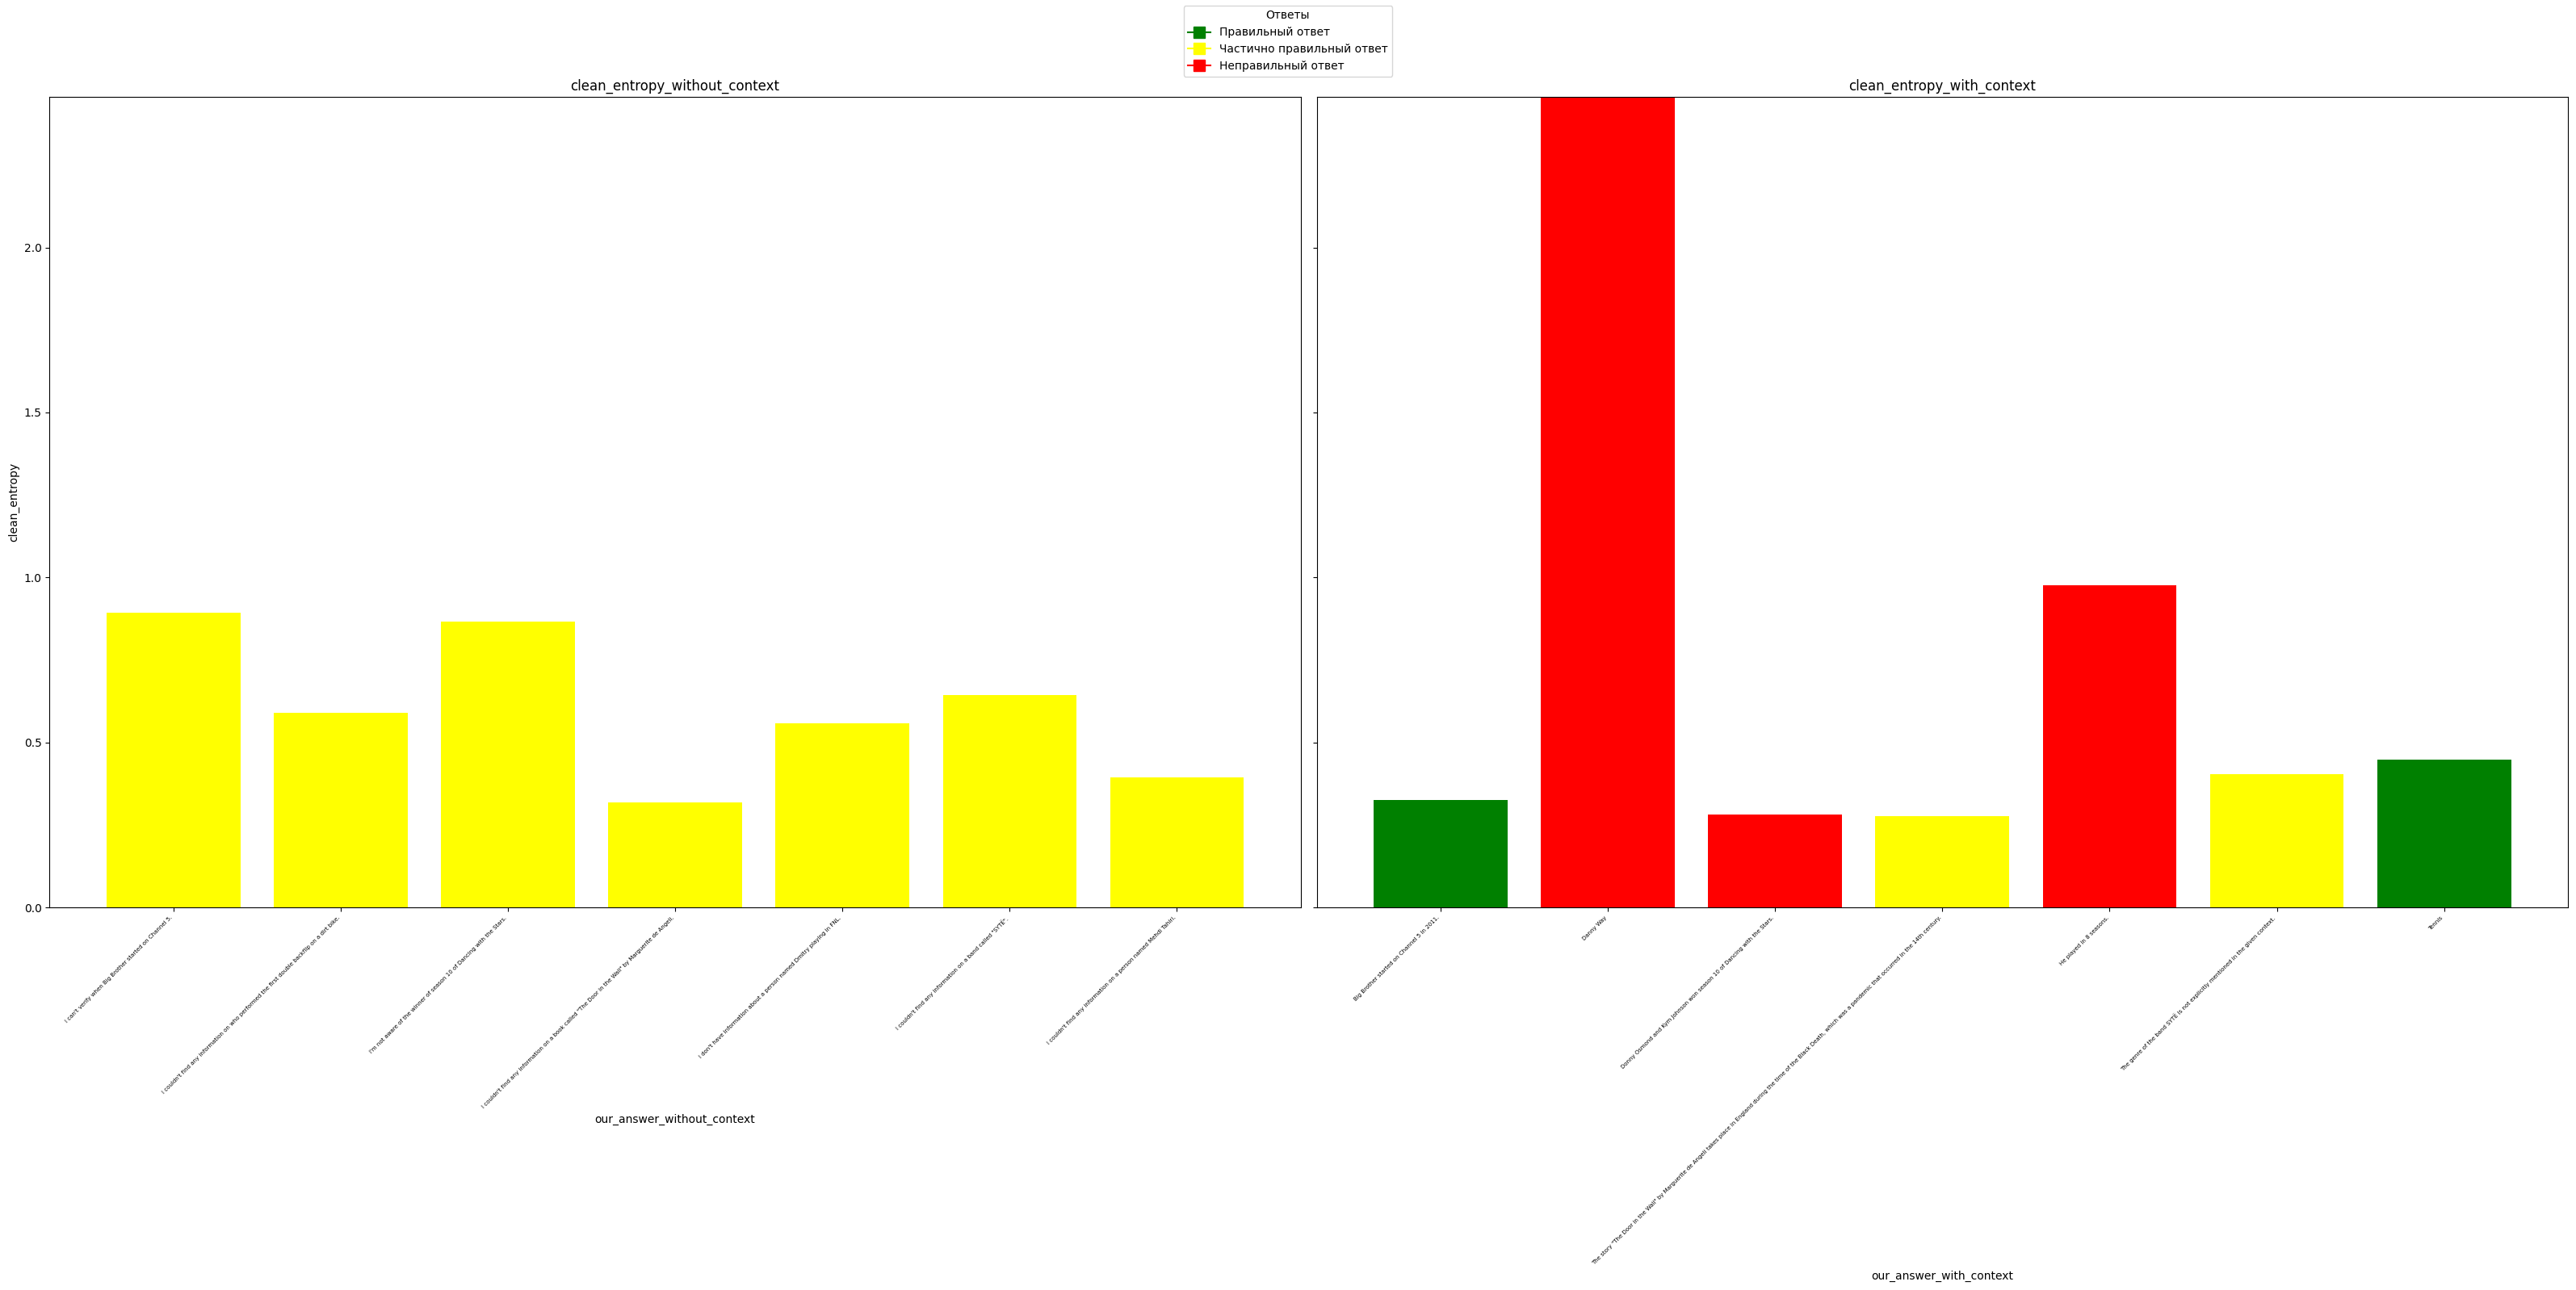

In [30]:
max_y = max(eval_dataset['clean_entropy_without_context'].max(), eval_dataset['clean_entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('clean_entropy')
ax1.set_title('clean_entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('clean_entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_2678468/543706121.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
/tmp/ipykernel_2678468/543706121.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)


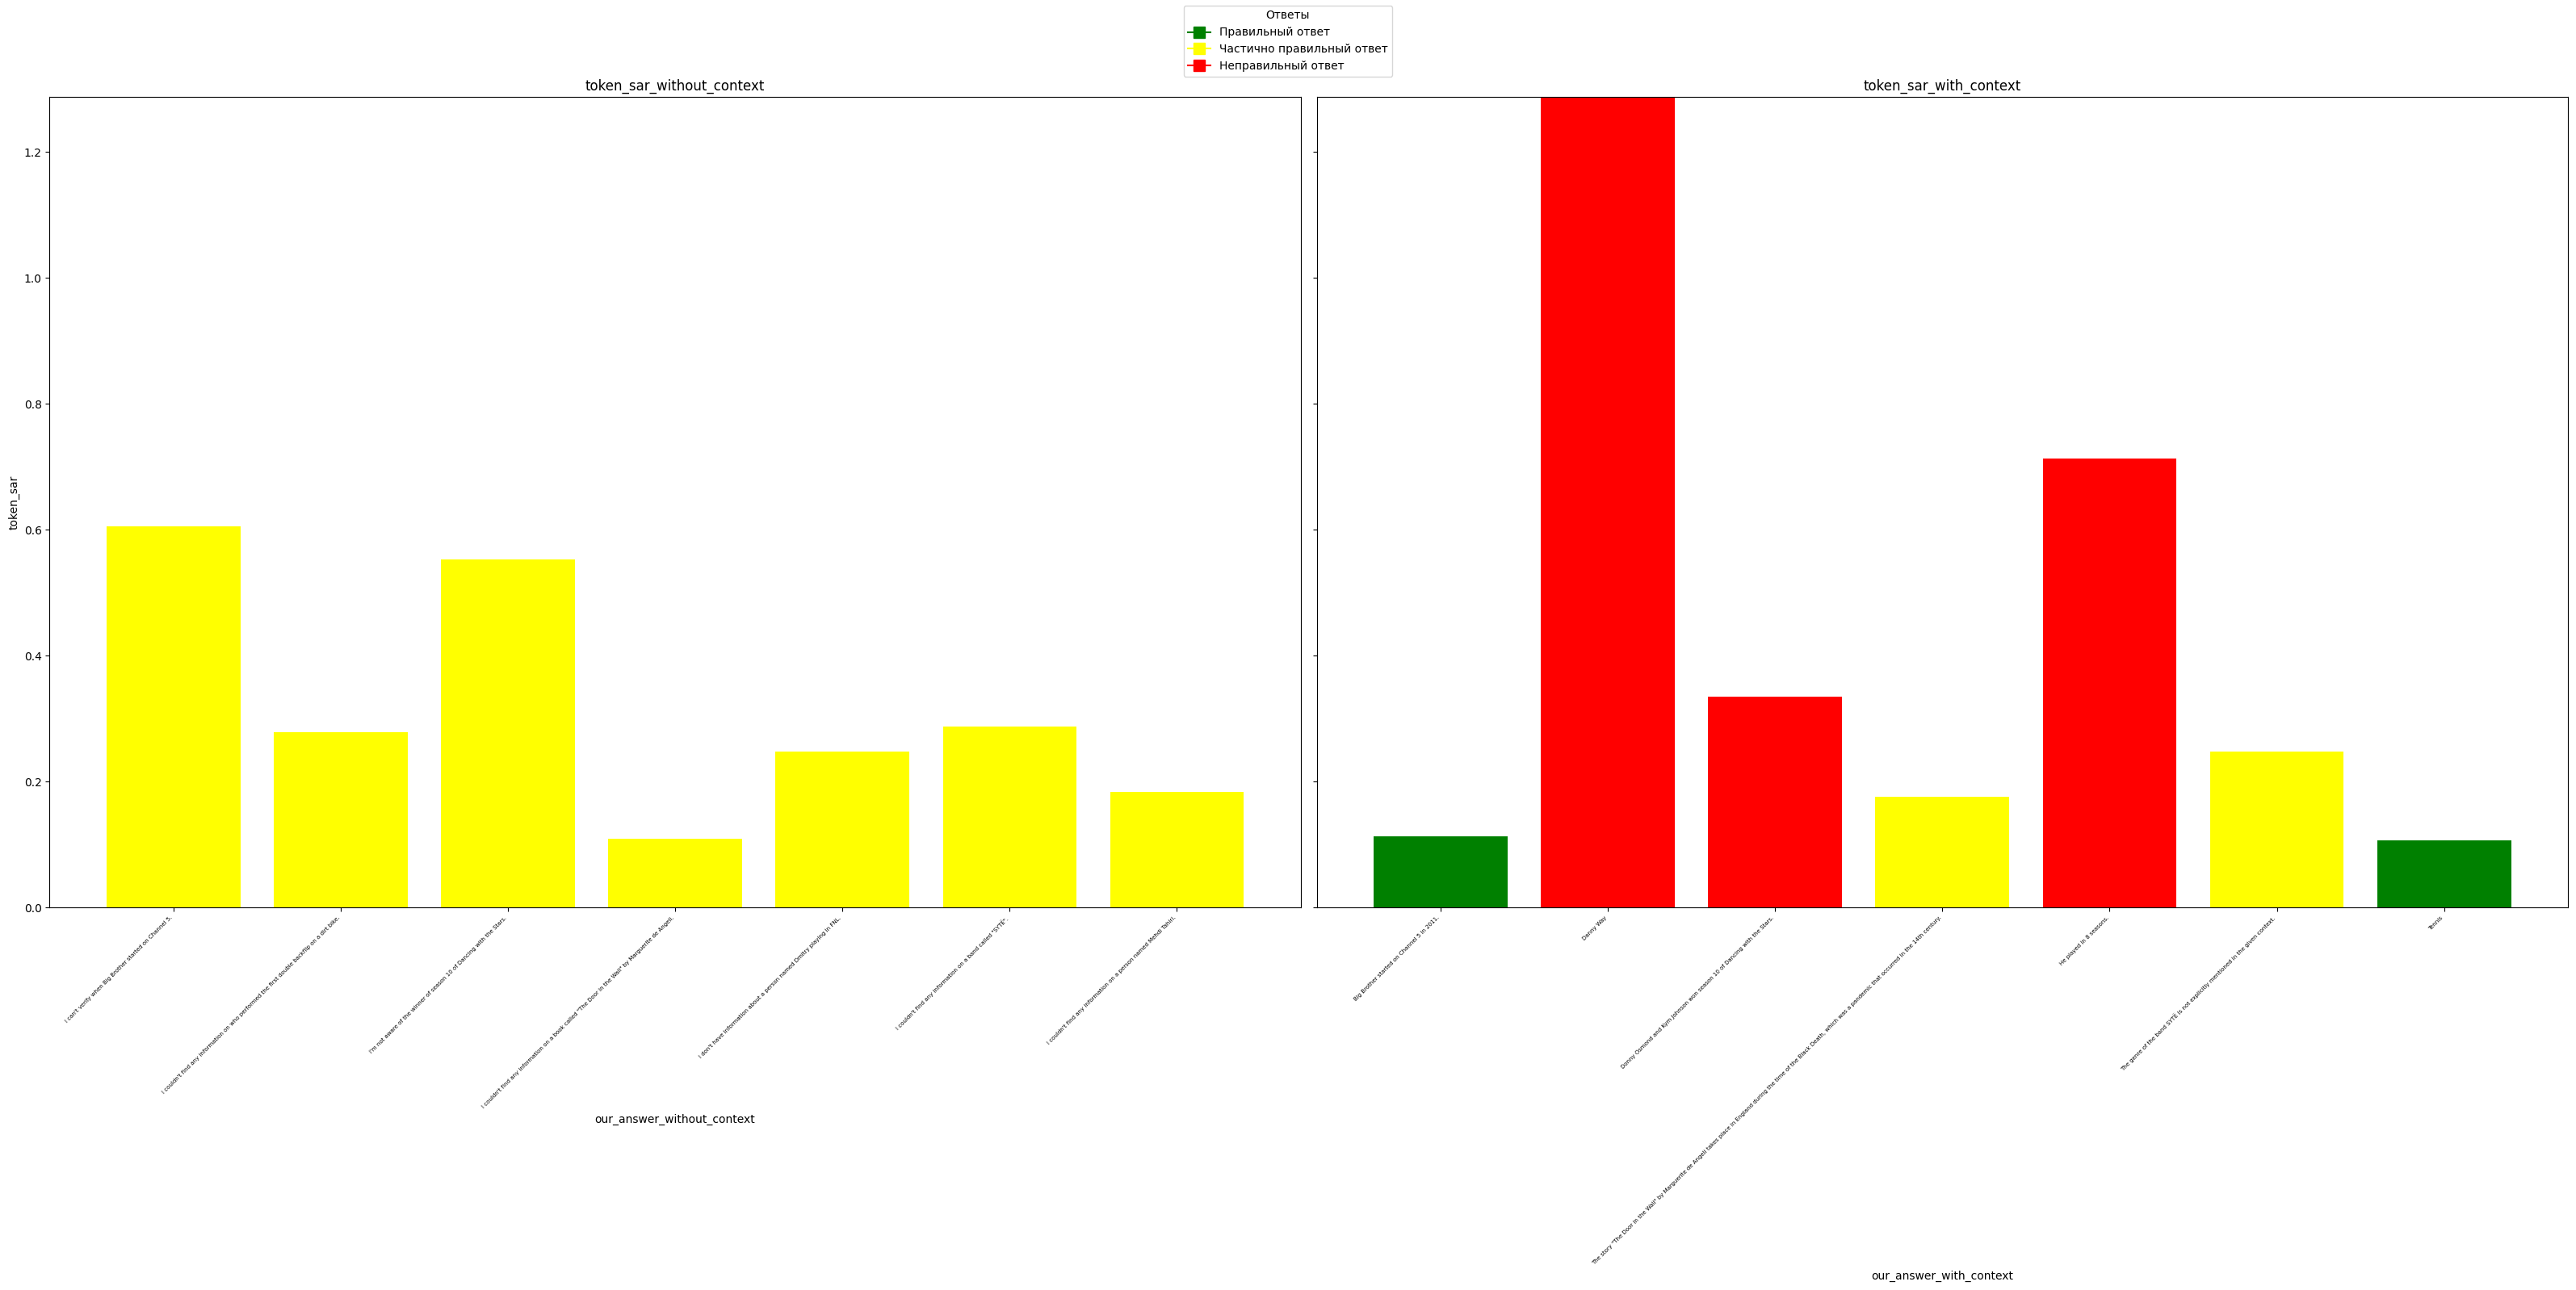

In [31]:
max_y = max(eval_dataset['token_sar_without_context'].max(), eval_dataset['token_sar_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('token_sar')
ax1.set_title('token_sar_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('token_sar_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Full dataset

In [51]:
from datasets import load_dataset

nq_dataset = load_dataset('cjlovering/natural-questions-short')['train'].shuffle(seed=42).select(range(1000)).to_pandas()
nq_dataset = nq_dataset[['contexts', 'questions', 'answers']]
nq_dataset['questions'] = nq_dataset['questions'].apply(lambda x: x[0]['input_text'])
nq_dataset['answers'] = nq_dataset['answers'].apply(lambda x: x[0]['span_text'])
nq_dataset = nq_dataset.rename(columns={'questions': 'question', 'answers': 'golden_answer', 'contexts': 'context'})

In [ ]:
nq_dataset

In [ ]:
for index, row in tqdm(nq_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    nq_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    nq_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    nq_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    nq_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    nq_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    nq_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    nq_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    nq_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)
    
nq_dataset.to_csv('data/nq_dataset_with_generated_answers.csv')

16it [14:45, 47.57s/it]